# Example: Quantum-Boltzmann-Machine Implementation on Dynex

Quantum computing algorithms for machine learning harness the power of quantum mechanics to enhance various aspects of machine learning tasks. Here is a summary of some prominent quantum computing algorithms for machine learning:
 
1. **Quantum Support Vector Machine (QSVM):** QSVM is a quantum-inspired algorithm that aims to classify data using a quantum kernel function. It leverages the concept of quantum superposition and quantum feature mapping to potentially provide computational advantages over classical SVM algorithms in certain scenarios.
 
 
2. **Quantum Principal Component Analysis (QPCA):** QPCA is a quantum version of the classical Principal Component Analysis (PCA) algorithm. It utilizes quantum linear algebra techniques to extract the principal components from high-dimensional data, potentially enabling more efficient dimensionality reduction in quantum machine learning.
 
 
3. **Quantum Neural Networks (QNN):** QNNs are quantum counterparts of classical neural networks. They leverage quantum principles, such as quantum superposition and entanglement, to process and manipulate data. QNNs hold the potential to learn complex patterns and perform tasks like classification and regression, benefiting from quantum parallelism.
 
 
4. **Quantum K-Means Clustering:** Quantum K-means is a quantum-inspired variant of the classical K-means clustering algorithm. It uses quantum algorithms to accelerate the clustering process by exploring multiple solutions simultaneously. Quantum K-means has the potential to speed up clustering tasks for large-scale datasets.
 
 
5. **Quantum Boltzmann Machines (QBMs):** QBMs are quantum analogues of classical Boltzmann Machines, which are generative models used for unsupervised learning. QBMs employ quantum annealing to sample from a probability distribution and learn patterns and structures in the data.
 
 
6. **Quantum Support Vector Regression (QSVR):** QSVR extends the concept of QSVM to regression tasks. It uses quantum computing techniques to perform regression analysis, potentially offering advantages in terms of efficiency and accuracy over classical regression algorithms.
 
As both, Quantum computing and Neuromorphic computing are sharing similar efficiency, all the algorithms above can be computed efficiently on the Dynex platform, but without the limitations of number of available qubits, error correction or availability.

A new approach using simulated quantum annealing (SQA) to numerically simulate quantum sampling in a deep Boltzmann machine (DBM) was presented in [1]. The authors proposed a framework for training the network as a quantum Boltzmann machine (QBM) in the presence of a significant transverse field for reinforcement learning. However, they demonstrated that the process of embedding Boltzmann machines in larger quantum annealer architectures is problematic when huge weights and biases are needed to emulate the Boltzmann machine’s logical nodes using chains and clusters of physical qubits. On the other hand, quantum annealing has the potential to speed up the sampling process exponentially.

The Dynex Neuromorphic Platform does not have these physical limitations and can therefore overcome such scaling problems and expand to large, real-world datasets and problems.  

We demonstrate a Quantum-Boltzmann-Machine (QBM) implementation using the Dynex platform to perform the computations and compare it with a traditional Restricted-Boltzmann-Machine (RBM). RBM is a well-known probabilistic unsupervised learning model which is learned by an algorithm called Contrastive Divergence. An important step of this algorithm is called Gibbs sampling – a method that returns random samples from a given probability distribution. We decided to conduct our experiments on the popular MNIST dataset considered a standard benchmark in many of the machine learning and image recognition subfields. The implementation follows a highly optimised QUBO formulation available at [2].

## Problem Description 

Restricted Boltzmann Machine is a variant of a Boltzman Machine – a stochastic, generative machine learning model inspired by statistical physics. It can model the underlying probability distribution of a training dataset. An RBM is a bipartite graph with two groups of nodes called visible and hidden. Learning an RBM corresponds to fitting its parameters such that the distribution represented by the RBM models the distribution underlying the training dataset. There is a weighted connection between each pair of vertices from different layers. A bias value is also associated with each vertex from both layers:

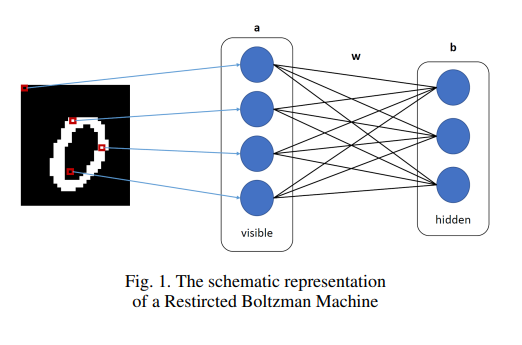

An RBM is an energy-based, probabilistic model, which means that there is a scalar value assigned to each possible state. The probability of observing a given state depends on the energy function. We refer to the equations in the references.

## Quantum Extensions to RBM 

The Dynex Platofrm and the D-wave Quantum Annealing algorithm provide an efficient way to solve such a function.
In order to do that, a QUBO (Quadratic Unconstrained Binary Optimization) Eq. (11) needs to be constructed:

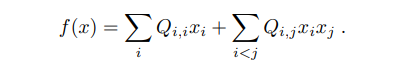

In the next step, the QUBO representation is transformed into a Binary Quadratic Model which can be used by
the Dynex Neuromorphic campler (as well as the D-wave quantum sampler) in order to obtain samples from
the model’s actual probability distribution. With an energy-based sampler it is possible to obtain accurate samples from the original distribution, which is computationally expensive for a classical computer. Instead of classical sampling as described in [2], we get the samples as a result of a quantum annealing process. The only
input we need to encode for the quantum annealer are model parameters. In this example will the quantum annealing process be replaced with the Dynex Neuromorphic sampler.

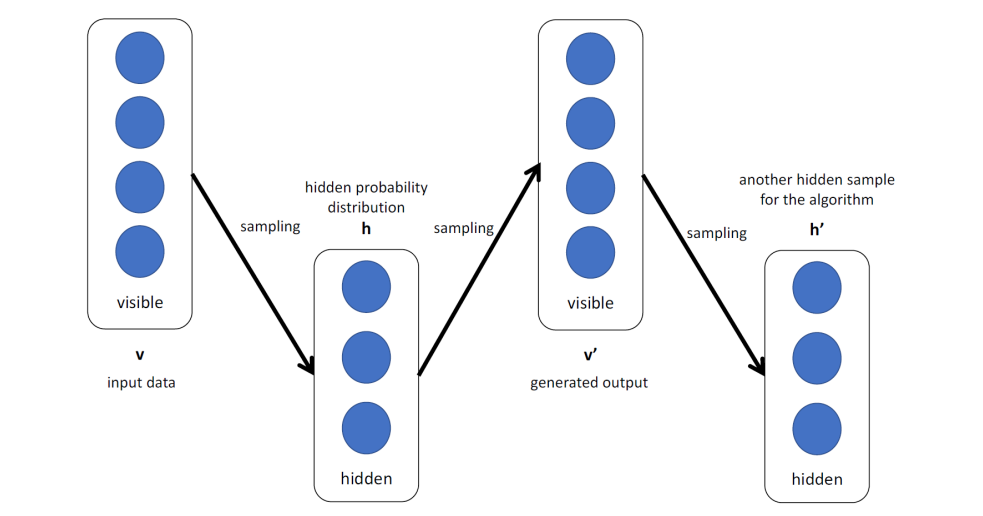
Schematic representation of the Contrastive Divergence algorithm

## Implementation 

We create a classical RBM model as well as a QBM where the classical sampling steps are being replaced by the output of the Dynex sampler. We test the models on the well known MNIST dataset of handwritten digital images with 60,000 training samples and 10,000 testing samples. To monitor the quality of the training process we apply a popular Mean Squared Error (MSE) measure between the input image which activates the sampling process and the generated image. We start by importing the libraries:

In [1]:
import dynex
import dimod

In [2]:
from itertools import product
import json
import random 
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import timeit
from tqdm import tqdm_notebook as tqdm
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import img_as_bool
import cv2 as cv
import random
import pandas as pd

In [4]:
import QRBM.MSQRBM
import QRBM.classicalRBM

We then define the settings. The MNIST dataset consists of images of size 28 x 28 pixels each. We also set the number of epochs for training the traditional RBM. The input size of the network is 784 (based on the image size) and a hidden layer of size 60.

In [5]:
image_height = 28
image_width = 28

# images will be flattened
len_x = image_height * image_width
len_y = 0

digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
THRESHOLD = 100
n_hidden = 60
qpu = False
epochs = 500 
lr = 0.1

The MNIST dataset can be downloaded from https://www.kaggle.com/datasets/oddrationale/mnist-in-csv and will be loaded in a DataFrame object:

In [6]:
mnist_dataset = pd.read_csv('datasets/mnist_train.csv')
mnist_test = pd.read_csv('datasets/mnist_test.csv')

We then preapre the train and test set:

In [7]:
X_train = mnist_dataset.values[:,1:]
X_train2 = mnist_dataset.values[:,:]

X_test = mnist_test.values[:,1:]
X_test2 = mnist_test.values[:,:]

X_train3 = []
X_test3 = []

for digit in digits:
    X_train3.append(mnist_dataset.values[np.where(mnist_dataset.values[:,0] == digit), 1:][0])
    X_test3.append(mnist_test.values[np.where(mnist_test.values[:,0] == digit), 1:][0])

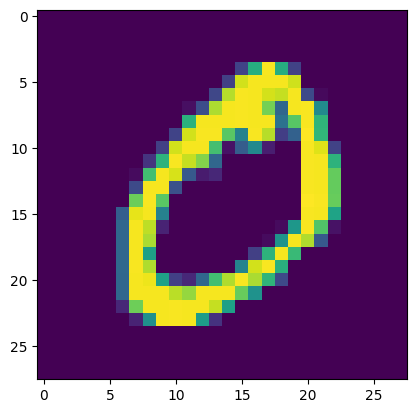

In [8]:
imgs = []
imgs_test = []
for digit_index in range(len(digits)):
    imgs.append(np.resize(X_train3[digit_index], (len(X_train3[digit_index]), 28, 28)) / 255)
    imgs_test.append(np.resize(X_test3[digit_index], (len(X_test3[digit_index]), 28, 28)) / 255)
    
plt.imshow(imgs[0][0])
plt.show()

Before feeding the data to the model, we have to perform some pre-processing steps due to the fact that an RBM
can only process binary data. We transformed the original MNIST images to binary representation using a threshold of 100 pixel brightness out of 0÷255 greyscale, and also flatten the images so they can fit into the 1-dimensional RBM visible layer of length 28 x 28 = 784:

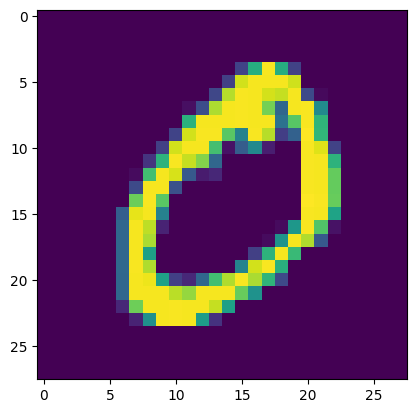

In [9]:
# resizing images
images_resized = []
images_resized_test = []
for digit_index in range(len(digits)):
    images_resized.append([resize(img, (image_width, image_height), anti_aliasing=True) for img in imgs[digit_index]])
    images_resized_test.append([resize(img, (image_width, image_height), anti_aliasing=True) for img in imgs_test[digit_index]])

plt.imshow(images_resized[0][0])
plt.show()

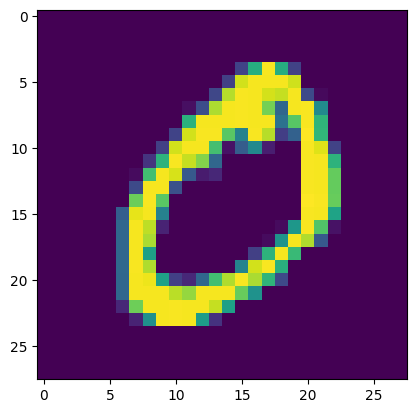

In [10]:
# normalizing images
images_normalized = []
images_normalized_test = []

for digit_index in range(len(digits)):
    images_normalized.append([cv.normalize(image_resized, image_resized, 0, 255, cv.NORM_MINMAX) for image_resized in images_resized[digit_index]])
    images_normalized_test.append([cv.normalize(image_resized, image_resized, 0, 255, cv.NORM_MINMAX) for image_resized in images_resized_test[digit_index]])

plt.imshow(images_normalized[0][0])
plt.show()

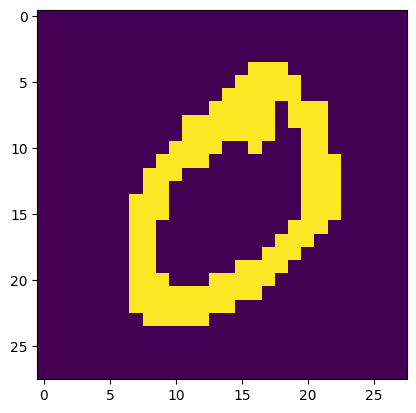

In [11]:
# converting to binary
data = []
data_test = []
for digit_index in range(len(digits)):
    data.append([np.where(image_resized > THRESHOLD, 1, 0) for image_resized in images_resized[digit_index]])
    data_test.append([np.where(image_resized > THRESHOLD, 1, 0) for image_resized in images_resized_test[digit_index]])

plt.imshow(data[0][0])
plt.show()

In [12]:
# flattening the image
input_data = []
input_data_test = []
for digit_index in range(len(digits)):
    input_data.append([x.flatten().tolist() for x in data[digit_index]])
    input_data_test.append([x.flatten().tolist() for x in data_test[digit_index]])
    

In [13]:
# save layer features to file:
import pickle
pickle.dump(input_data, open('datasets/MNIST.pickle', 'wb'))
pickle.dump(input_data_test, open('datasets/MNIST_test.pickle', 'wb'))

Now after preprocssing, we can prepare and shuffle the training and test data:

In [14]:
result_picture_tab = []
for digit_index in range(len(digits)):
    result_picture_tab.append(np.mean(input_data_test[digit_index], axis = 0))

In [15]:
# shuffling the training data
for digit in digits:
    flat_input_data = [item for sublist in input_data for item in sublist]
    flat_input_data_test = [item for sublist in input_data_test for item in sublist]

random.shuffle(flat_input_data)
random.shuffle(flat_input_data_test)

## Traditional RBM

For benchmarking and testing the correctness of the RBM implementation, we train a traditional RBM by maximizing the product of probabilities assigned to some training set V and optimizing the weight vector using Constrastive Divergence (CD)[3]:

1. Take a training sample v,
   compute the probabilities of the hidden units and
   sample a hidden activation vector h from this probability distribution.

2. Compute the outer product of v and h and call this the positive gradient.

3. From h, sample a reconstruction v' of the visible units,
   then resample the hidden activations h' from this. (Gibbs sampling step)

4. Compute the outer product of v' and h' and call this the negative gradient.

5. Let the update to the weight matrix W be the positive gradient minus the negative gradient,
   times some learning rate
   
6. Update the biases a and b analogously: a=epsilon (v-v'), b=epsilon (h-h')

            

We als added learning rate decay, which is a mechanism that decreases the learning rate α every couple of iterations. It is used to further optimize the learning process after getting stuck close to the optimum. We also added Momentum, which is a popular improvement of gradient based algorithms, such as SGD or Adam. The main idea behind the method is to calculate the gradient, not only based on the current data sample, but also the previous gradient direction. Another improvement that was added is a different variant of the learning algorithm called persistent CD. The main difference is that in most iterations, instead of taking the input data as vector v, we use the v' vector from the previous iteration to calculate the negative phase of the gradient

In [16]:
bm = QRBM.classicalRBM.classicalRBM(n_visible=len_x, n_hidden=n_hidden, use_tqdm=True);
bm.image_height = image_height
bm.tqdm = tqdm
bm.result_picture_tab = result_picture_tab

  0%|          | 0/500 [00:00<?, ?it/s]

Better model found at epoch 0 mse= 0.30739795918367346
Better model found at epoch 1 mse= 0.2997448979591837
Better model found at epoch 2 mse= 0.20535714285714285
Better model found at epoch 7 mse= 0.17857142857142858
Better model found at epoch 8 mse= 0.1568877551020408
Better model found at epoch 9 mse= 0.1556122448979592
Better model found at epoch 14 mse= 0.1096938775510204
Better model found at epoch 18 mse= 0.10586734693877552
Better model found at epoch 24 mse= 0.09438775510204081
Better model found at epoch 26 mse= 0.07908163265306123
Better model found at epoch 47 mse= 0.058673469387755105
Better model found at epoch 68 mse= 0.04974489795918367
lr= 0.09000000000000001
Better model found at epoch 106 mse= 0.042091836734693876
Better model found at epoch 198 mse= 0.036989795918367346
lr= 0.08100000000000002
Better model found at epoch 200 mse= 0.03188775510204082
Better model found at epoch 214 mse= 0.030612244897959183
Better model found at epoch 236 mse= 0.029336734693877552


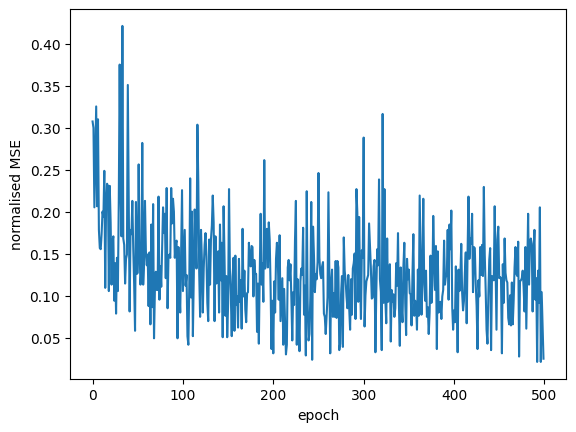

In [17]:
bm.train(flat_input_data, len_x, len_y, epochs = epochs, lr = lr, lr_decay = 0.1)

Normalised MSE values changing with an increasing number of epochs for a two digit problem

## QBM on the Dynex Neuromorphic Platform

In our QBM, the classical sampling steps are being replaced by the output of the Dynex Neuromorphic sampler:

In [18]:
bm = QRBM.MSQRBM.MSQRBM(n_visible=len_x, n_hidden=n_hidden, qpu=qpu)
bm.image_height = image_height
bm.tqdm = tqdm
bm.result_picture_tab = result_picture_tab

We expect the QBM to evolve significantly faster to lower MSE values and therefore reduce the training epochs by 96% to just 20 training iterations:

  0%|          | 0/10 [00:00<?, ?it/s]

Better model found at epoch 0 mse= 0.14923469387755103
lr =  0.09000000000000001
Better model found at epoch 1 mse= 0.09948979591836735
Better model found at epoch 2 mse= 0.06505102040816327
lr =  0.08100000000000002
lr =  0.07290000000000002
lr =  0.06561000000000002
lr =  0.05904900000000002


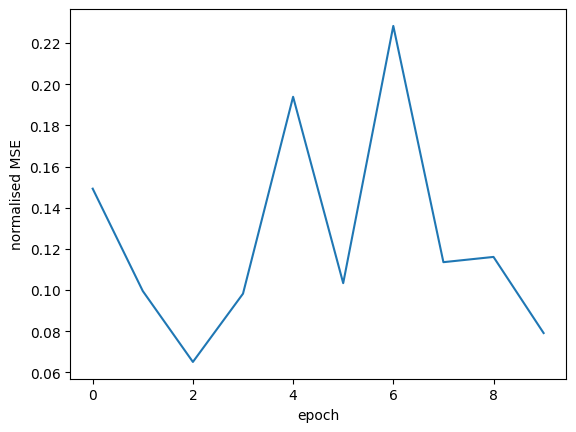

In [19]:
bm.train(flat_input_data, len_x, len_y, epochs = 10, lr = lr, lr_decay = 0.1)

## Performance Comparison RBM vs QBM 

The QBM evolves much faster to an attractive Mean Squared Error (MSE) than the traditional RBM, which means a significant lower amount of training iterations is required. In addition is the achieved MSE much lower, meaning the QBM created models have higher accuracy. This finding is in line with the results from the papers referenced. However, [1] demonstrated that the process of embedding Boltzmann machines in larger quantum annealer architectures is problematic when huge weights and biases are needed to emulate the Boltzmann machine’s logical nodes using chains and clusters of physical qubits because of the limited number of qubits availabe. The Dynex Neuromorphic platform provides a more scalable alternative and can used to train models with millions of variables. Especially when real-world models are to be trained, the number of training iterations and accuracy are important.

References:

[1] D. Crawford, A. Levit, N. Ghadermarzy, J.S. Oberoi, P. Ronagh, Reinforcement Learning Using Quantum Boltzmann
Machines, arXiv: 1612.05695 (2016).

[2] K. Kurowski, M. Slysz, M. Subocz, R. Rozycki, Applying a Quantum Annealing Based Restricted Boltzmann Machine
for MNIST Handwritten Digit Classification, CMST, Volume 27 (3) 2021, 99-107

[3] https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine

[4] K. Kurowski, J. Weglarz, M. Subocz, R. Rozycki, G. Waligóra, Hybrid Quantum Annealing Heuristic Method for
Solving Job Shop Scheduling Problem, [In:] Computational Science – ICCS 2020. Lecture Notes in Computer Science 12142, Eds. V.V. Krzhizhanovskaya, G. Závodszky, M.H. Lees, J.J. Dongarra, P.M.A. Sloot, S. Brissos, J. Teixeira, Springer, Cham (2020).

[5] J. Biamonte, P. Wittek, N. Pancotti, P. Rebentrost, N. Wiebe, S. Lloyd, Quantum machine learning, Nature 549, 195–202 (2017).

[6] S. Lloyd, M. Mohseni, P. Rebentrost, Quantum algorithms for supervised and unsupervised machine learning, arXiv: 1307.0411 (2013).

[7] M. Benedetti, J. Realpe-Gomez, A. Perdomo-Ortiz, Quantum-assisted helmholtz machines: a quantum-classical deep
learning framework for industrial datasets in near-term devices, arXiv: 1708.09784 (2017).